# <center>Final Project; Algorithms in Modern Statistics </center>
**Submitted by**: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

You might also need to run the next block (not as comments).

In [1]:
#!pip install plotly-express
#!pip install bayesian-optimization
#!pip install shap

## Table of Contents:
* [Useful Functions](#useful-functions)
    * [Plottings](#Plottings)
    * [DataFrame Transformations](#DataFrame-Transformations)
    * [ML, Optimization and Metrics](#mmo)
* [Part 1: EDA](#eda)
    * [Categorical Data](#cat)
    * [Numeric Data](#num)
    * [Statistical Relationship Analysis](#sra)
        * [Dimensionality Reduction](#pca)
* [Part 2: Hypothesis Testing](#hypt)
    * [Effect Size](#effs)
    * [Gender x Grades](#ttest)
    * [Number of Students in Class x Grades](#ttest2)

* [Part 3: Clusterring the Data](#clusters)

* [Part 4: Regression Modelling](#reg)
    * [Students' Scores ; Gradient Boosting Regressor](#gbr)
    * [Class Scores Average ; SVM Regressor](#svm)

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, explained_variance_score, median_absolute_error, r2_score, make_scorer


from scipy import stats, special
from bayes_opt import BayesianOptimization
import shap

from typing import Union
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
shap.initjs()

%matplotlib inline

## Useful Functions <a class="anchor" id="useful-functions"></a>

### Plottings <a class="anchor" id="Plottings"></a>

In [3]:
def plot_decomposition(est, data: pd.DataFrame, color, dim=2, method='px', hover_data=None, marker=None,
                       exclude_dtypes=None, drop_color=False,
                       drop_columns=None, title='', return_estimator=False, show=True):
    _df = data.copy()
    if drop_columns:
        _df = _df.drop(columns=drop_columns)
    if exclude_dtypes:
        _df = _df.select_dtypes(exclude=exclude_dtypes)
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].apply(lambda _z: _z.astype('category').cat.codes)
    color = data[color].copy()
    _df = _df.drop(columns = [color.name]) if color.name in _df.columns and drop_color else _df

    est = est.fit(StandardScaler().fit_transform(_df))
    _x = est.transform(StandardScaler().fit_transform(_df))
    
    dim_cols = [f'PC{i} : Most Important - {_df.columns[np.abs(est.components_[i-1]).argmax()]}' for i in range(1, dim+1)]
    _x = pd.DataFrame(_x[:, :dim], columns=dim_cols)
    
    if hover_data:
        if type(hover_data) == str:
            hover_data = [hover_data]
        _x[hover_data] = data[hover_data]
    else:
        hover_data = _df.columns
        _x[hover_data] = data[hover_data]

    _x[color.name] = color
    
    if dim == 2:      
        if method == 'px':
            fig = px.scatter(_x, x=dim_cols[0], y=dim_cols[1], color=color.name, hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            sns.scatterplot(data=_x, x=dim_cols[0], y=dim_cols[1] ,hue=color.name, style=marker)

    elif dim == 3:
        if method == 'px':
            fig = px.scatter_3d(_x, x=dim_cols[0], y=dim_cols[1], z=dim_cols[2], color=color.name, 
                                hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            ax = plt.axes(projection='3d')
            cax = ax.scatter(_x[dim_cols[0]], _x[dim_cols[1]], _x[dim_cols[2]], c=color, marker='o')
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])
            ax.set_zlabel(dim_cols[2])
    if method == 'px':
        fig.update_layout(
            title={
                'text': title,
                'x': 0.5,
                'y': 0.95,
                'xanchor': 'center',
                'yanchor': 'top'}, coloraxis_colorbar=dict(yanchor="top", x=-0.25,y=1))
        
        if show:
            fig.show()
    else:
        plt.title(title)
        if show:
            plt.show()
    if return_estimator:
        return est
    

def biplot(est, data, method='plt', show=True):
    _df = data.copy()
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].apply(lambda _z: _z.astype('category').cat.codes)
    feature_names = _df.columns
    est = est.fit(StandardScaler().fit_transform(_df))
    loadings = est.components_.T * np.sqrt(est.explained_variance_)
    
    for i, (_x, _y) in enumerate(loadings):
        if method == 'plt':
            plt.annotate(feature_names[i], (0, 0), (_x , _y), arrowprops = {'arrowstyle': '<-', 'color': 'black'})
    
    if method == 'plt':
        plt.xlabel('$PC_{1}$')
        plt.ylabel('$PC_{2}$')
        plt.title('Feature Influence on Each $PC$ (loading)')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        if show:
            plt.show()
    
def plot_xVarRatio(data, method='plt', show=True):
    _df = data.copy()
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].apply(lambda _z: _z.astype('category').cat.codes)
    feature_names = _df.columns
    est = PCA(n_components=len(feature_names), svd_solver='full').fit(StandardScaler().fit_transform(_df))
    # feature_names = [feature_names[k] for k in np.abs(est.components_).argmax(axis=1)]    
    if method == 'plt':
        plt.xlabel('number of $PC$s')
        plt.ylabel('explained variance ratio')
        plt.title(r'Explained Variance Ratio $\times$ number of $PC$s')
        _x = np.arange(0, est.n_components_)
        plt.plot(_x, est.explained_variance_ratio_, '-o', label='non-cummulative', c='b')
        plt.plot(_x, est.explained_variance_ratio_.cumsum(), '-o', label='cummulative', c='r')
        plt.legend(fancybox=True, shadow=True, facecolor='coral', edgecolor='gold')
        if show:
            plt.show()
        

def plot_reg(y_true, y_pred):
    _x = np.arange(0, len(y_pred))
    inds = np.argsort(y_true)
    plt.plot(_x, np.sort(y_true), '-o',label='$f(x)$')
    plt.plot(_x, y_pred[inds], '-o', label='$\hat{f(x)}$')
    plt.legend()
    plt.xticks([])
    plt.show()
    
    
def plot_important_features(coef, feature_names, top_n=20, ax=None, labels: dict = None, flip=False):
    if ax is None:
        ax = plt.gca()
    top_n = min(top_n, len(coef))
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    _x0 = np.arange(0, top_n, dtype=int)
    combined_inds = inds[sort_sign]
    new_c = coef[combined_inds]
    if labels is None:
        ax.bar(_x0, new_c)
    else:
        colors = ['k', 'g', 'r', 'b', 'y']
        for i, (k, v) in enumerate(labels.items()):
            _v = lambda x: eval(v.format('x'))
            ax.bar(_x0[_v(new_c)], new_c[_v(new_c)], color=colors[i], label=k)
        ax.legend(shadow=True, fancybox=True)
    ax.set_xticks(_x0)
    if flip:
        ax.set_xticklabels([k[::-1] for k in np.array(feature_names)[combined_inds]], rotation=60, ha="right")
    else:
        ax.set_xticklabels([k for k in np.array(feature_names)[combined_inds]], rotation=60, ha="right")
    

### DataFrame Transformations <a class="anchor" id="DataFrame-Transformations"></a>

In [4]:
def split_xy(data: pd.DataFrame, by: str, x: str = None):
    new_df = []
    for _val in data[by].unique():
        if x is not None:
            new_df.append(data.loc[data[by] == _val, x].copy().reset_index(drop=True))
        else:
            new_df.append(data.loc[data[by] == _val].copy().reset_index(drop=True))
    return new_df

### ML, Optimization and Metrics <a class="anchor" id="mmo"></a>

In [5]:
def cohens_d_test(data, target, by, title=None):
    if title is None:
        title = 'results' 
    _x1, _x2 = split_xy(data, by, target)
    n1 = len(_x1)
    n2 = len(_x2)
    _x1 = _x1.to_numpy()
    _x2 = _x2.to_numpy()
    
    def s2(_x):
        denum = len(_x) - 1
        num = np.sum((_x - _x.mean())**2)
        return num / denum
    
    s = np.sqrt(((n1 - 1)*s2(_x1) + (n2-1)*s2(_x2)) / (n1 + n2))
    
    d = abs(_x1.mean() - _x2.mean()) / s
    effects = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large', 'Huge']
    sizes = np.array([0.01, 0.2, 0.5, 0.8, 1.0, 2.0])
    res = [len(_x1), len(_x2), _x1.mean(), _x2.mean(), s, d, effects[np.argmin(np.abs(sizes - d))]]
    for i in range(4):
        res[i] = round(res[i], 2)
    
    return pd.DataFrame(data=np.expand_dims(res, 1), index=[r'size( $x_1$ )',r'size( $x_2$ )','$E[x_1]$', '$E[x_2]$', '$s$', '$d$', 'Effect Size'], columns=[title])

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def regression_summary(y_true, y_pred, title=None):
    if title is None:
        title = 'Regression Summary'
    mets = [RMSE(y_true, y_pred), 
            mean_absolute_error(y_true, y_pred),
            r2_score(y_true, y_pred), 
            median_absolute_error(y_true, y_pred), 
            explained_variance_score(y_true, y_pred)]
    
    names = ['RMSE', 'MAE', '$R^2$', 'MedAE', 'Explained Variance']
    
    for i in range(len(mets)):
        mets[i] = round(mets[i], 3)
        
    return pd.DataFrame(data=np.expand_dims(mets, 1), index=names, columns=[title])

def optimize(estimator, data, target, settings: dict, extra_steps: Union[list, tuple] = None,
             cv_params: dict = dict(scoring='f1_macro', cv=5), verbose=2,
             opt_params: dict = dict(n_iter=20),
             max_min='max'):

    """
    :param estimator: a sklearn/xgboost trainable object
    :param data: the training data
    :param target: the training target
    :param settings: the model hyperparameters to be tuned with the optimization
    :param extra_steps: extra pipeline steps, prior to the model being optimized (data transformations)
    :param cv_params: parametrs/settings for the cross-validation (number of cv, scoring etc.)
    :param verbose: verbosity level of the bayesian optimization
    :param opt_params: parametrs/settings for the optimization
    :param max_min: whether the optimization should maximize or minimize the target metric
    :return: a sklearn/xgboost trainable object, set with the optimal parameters found by the optimization
    """

    if extra_steps is not None:
        if type(extra_steps) == tuple:
            extra_steps = [extra_steps]

    else:
        extra_steps = []

    def parse_parameter(_p, val):
        if 'dtype' not in settings[_p].keys():
            return val
        dtype = settings[_p]['dtype']
        if dtype in [float, int]:
            val = dtype(val)
            if 'f' in settings[_p].keys():
                return settings[_p]['f'](val)
            return val
        else:
            n = len(settings[_p]['space'])
            val = int(val)
            if val > n - 1:
                return settings[_p]['space'][-1]
            elif val < 0:
                return settings[_p]['space'][0]
            else:
                return settings[_p]['space'][val]

    def get_model(**params):
        for _p, val in params.items():
            params[_p] = parse_parameter(_p, val)

        model = estimator(**params)
        steps = extra_steps.copy()
        steps.append(('final_model', model))
        return Pipeline(steps=steps)

    def cv_model(**params):
        if max_min is 'max':
            cval = cross_val_score(get_model(**params), data, target, **cv_params, error_score=0).mean()
            if cval > 1e+6:
                cval = 0
        else:
            cval = cross_val_score(get_model(**params), data, target, **cv_params, error_score=-1e+6).mean()
            cval = np.max([cval, -1e+6])
        return cval

    pbounds = {}
    for k in settings.keys():
        if type(settings[k]['space']) == tuple:
            pbounds[k] = settings[k]['space']
        else:
            pbounds[k] = (0, len(settings[k]['space']))

    optimizer = BayesianOptimization(
        f=cv_model,
        pbounds=pbounds,
        verbose=verbose
    )
    optimizer.maximize(**opt_params)
    print("Final result:", optimizer.max)
    return get_model(**optimizer.max['params'])


-----------------------------------------

In [6]:
df = pd.read_csv('archive/test_scores.csv')
df['lunch'] = df['lunch'].apply(lambda _z: _z if _z == 'Does not qualify' else 'Qualifies')
df.head()

school school_setting school_type classroom teaching_method  n_student  \
0  ANKYI          Urban  Non-public       6OL        Standard       20.0   
1  ANKYI          Urban  Non-public       6OL        Standard       20.0   
2  ANKYI          Urban  Non-public       6OL        Standard       20.0   
3  ANKYI          Urban  Non-public       6OL        Standard       20.0   
4  ANKYI          Urban  Non-public       6OL        Standard       20.0   

  student_id  gender             lunch  pretest  posttest  
0      2FHT3  Female  Does not qualify     62.0      72.0  
1      3JIVH  Female  Does not qualify     66.0      79.0  
2      3XOWE    Male  Does not qualify     64.0      76.0  
3      556O0  Female  Does not qualify     61.0      77.0  
4      74LOE    Male  Does not qualify     64.0      76.0

## Part 1: EDA <a class="anchor" id="eda"></a>
The following part contains of:
- Data Visualizations
- General Statistics of Each Feature
- Visualizing Relationships Between Features
- Dimensionality Reduction

### Categorical Data <a class="anchor" id="cat"></a>

In [7]:
df.describe(include='object')

school school_setting school_type classroom teaching_method student_id  \
count    2133           2133        2133      2133            2133       2133   
unique     23              3           2        97               2       2133   
top     GOOBU          Urban      Public       18K        Standard      2FHT3   
freq      158            906        1582        31            1373          1   

       gender             lunch  
count    2133              2133  
unique      2                 2  
top      Male  Does not qualify  
freq     1077              1215

Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [8]:
df = df.drop(columns=['student_id'])

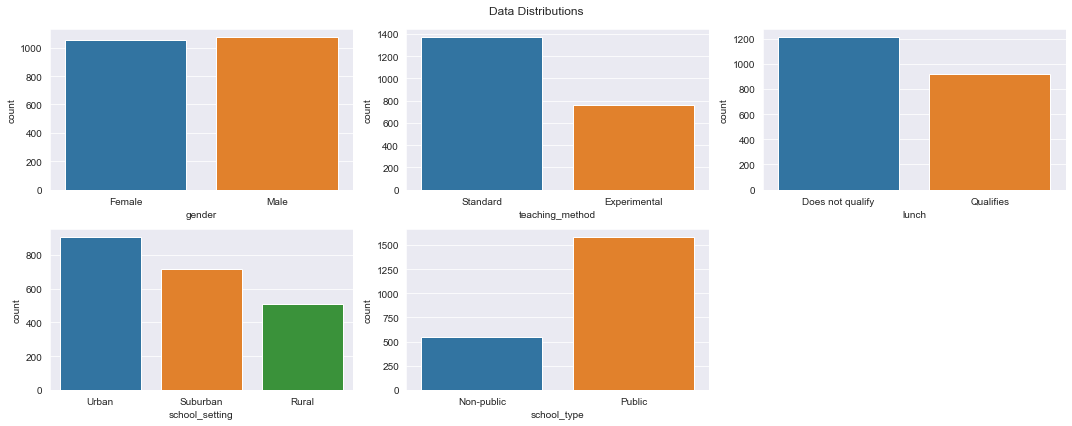

In [9]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

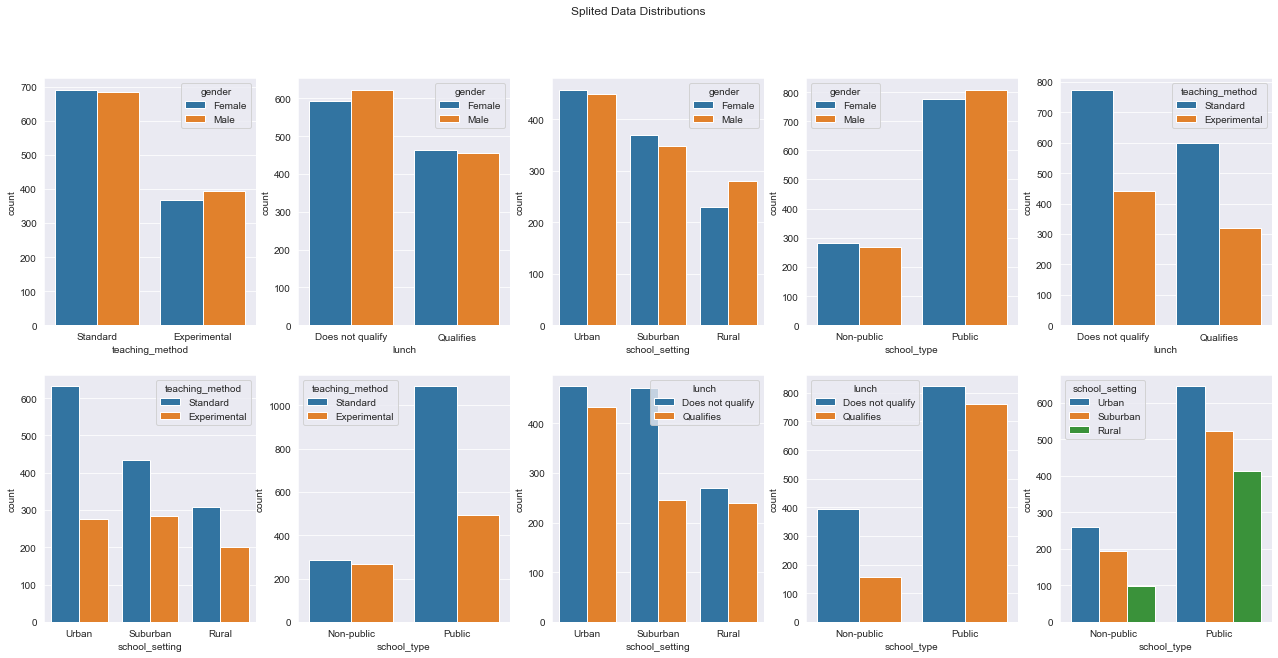

In [10]:
plt.figure(figsize=(22, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

We can already see differences in some of the features distributions when dividing them into separated groups;
- School type, divided by teaching method
- School type, divided by *lunch* feature
- Genders in different school settings

### Numeric Data <a class="anchor" id="num"></a>

In [11]:
df.describe()

n_student      pretest     posttest
count  2133.000000  2133.000000  2133.000000
mean     22.796531    54.955931    67.102203
std       4.228893    13.563101    13.986789
min      14.000000    22.000000    32.000000
25%      20.000000    44.000000    56.000000
50%      22.000000    56.000000    68.000000
75%      27.000000    65.000000    77.000000
max      31.000000    93.000000   100.000000

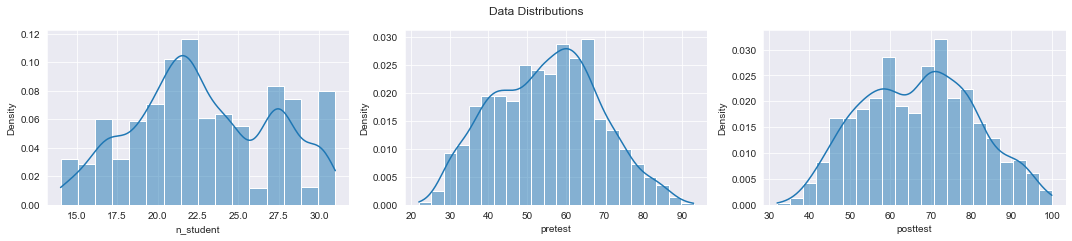

In [12]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['n_student', 'pretest', 'posttest']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=c, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

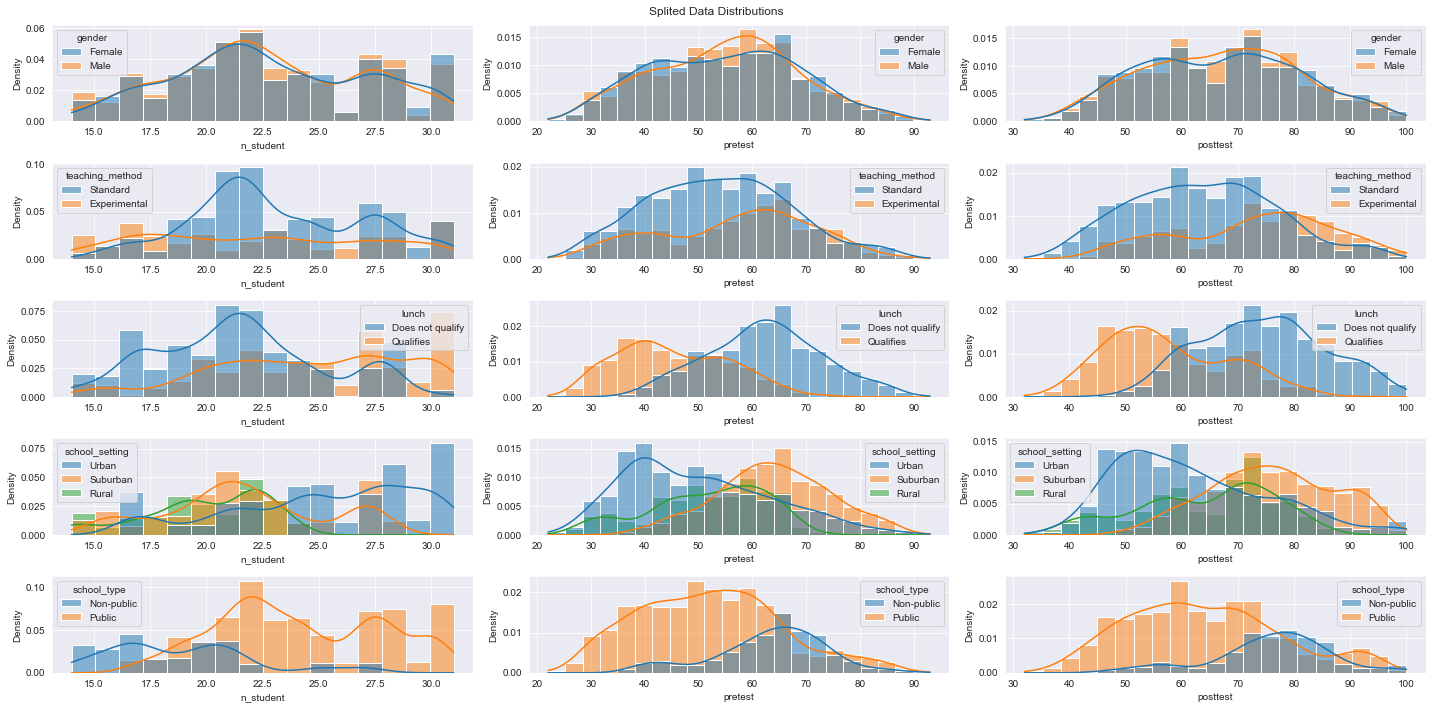

In [13]:
plt.figure(figsize=(20, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['n_student', 'pretest', 'posttest']):
        plt.subplot(5, 3, index)
        index += 1
        sns.histplot(data=df, x=col, hue=hue, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

### Statistical Relationship Analysis <a class="anchor" id="sra"></a>

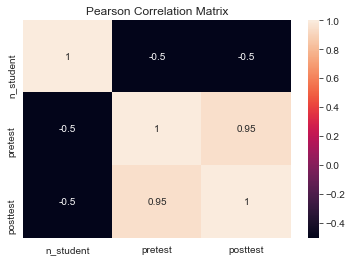

In [14]:
sns.heatmap(df[['n_student', 'pretest', 'posttest']].corr(), annot=True)
plt.title('Pearson Correlation Matrix')
plt.show()

Clearly, the pretest and posttest scores are very highly correlated, almost as if these were the same features to work with.


In [15]:
df = df.drop(columns=['pretest'])

Another interesting thing to investigate is whether the number of students in a class affects, significantly, the class GPA.

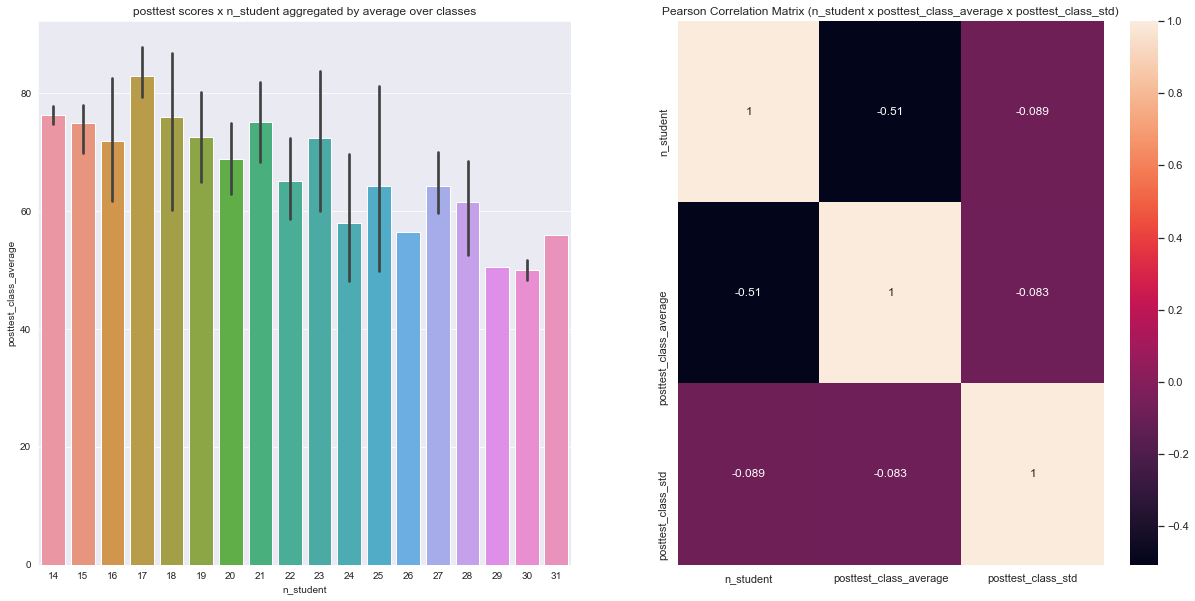

In [16]:
plt.figure(figsize=(21, 10))
plt.subplot(1, 2, 1)
plt.title('posttest scores x n_student aggregated by average over classes')

t_df = df[['posttest', 'classroom']].groupby('classroom').aggregate(['count', 'mean', 'std'])['posttest']
t_df = t_df.rename(columns={'count': 'n_student', 'mean': 'posttest_class_average', 'std': 'posttest_class_std'})

sns.set_theme(rc={'figure.figsize':(15,5)})
sns.barplot(data=t_df,x='n_student',y='posttest_class_average')

plt.subplot(1, 2, 2)
plt.title('Pearson Correlation Matrix (n_student x posttest_class_average x posttest_class_std)')
sns.heatmap(t_df.corr(), annot=True)

plt.show()

del(t_df)
t_df = None

We can see that the GPA of classes with 23 students or less are above 60 (passing grade). However, the coefficient between the two groups seems to be very low. Also, we can see that the standard deviation of scores within classes is **not** affected by the number of students in the class, meaning that any effect the number of students has on the class scores - is collective on the students, and not by a chance of having a 'specifically weak/strong' students in a class.

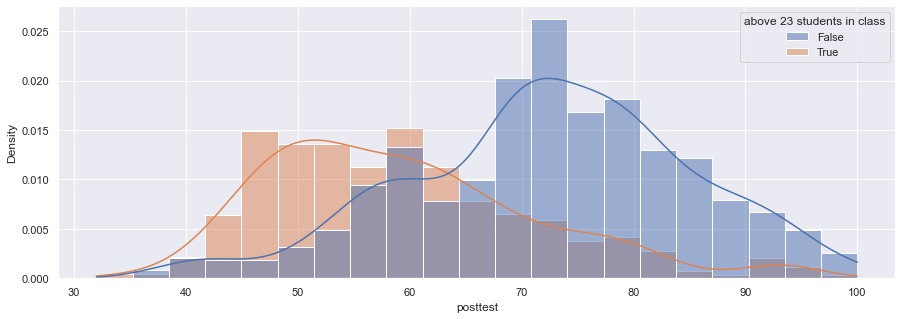

In [17]:
t_df = df.copy()
t_df['above 23 students in class'] = t_df['n_student'] > 23
sns.histplot(data=t_df, x='posttest', hue='above 23 students in class', kde=True, stat='density', ax=plt.gca())

del(t_df)
t_df = None
plt.show()

So the difference between the distributions seems quite big, and thats something we're going to have an hypothesis test about later on.

Next, we'd like to see the distributions of posttest grades variances within classrooms and schools, in order to understand whether this features are biased.

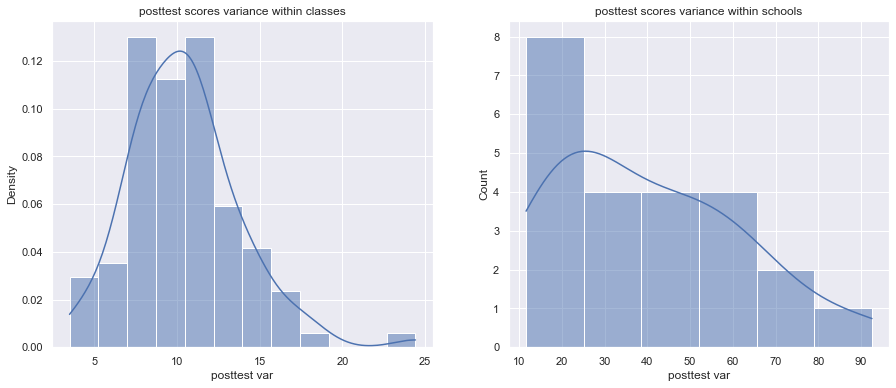

In [18]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('posttest scores variance within classes')
t_df = df.groupby('classroom').var()
sns.histplot(data=t_df, x='posttest', kde=True, stat='density', ax=plt.gca())
plt.xlabel('posttest var')
plt.subplot(1, 2, 2)
plt.title('posttest scores variance within schools')
t_df = df.groupby('school').var()
sns.histplot(data=t_df, x='posttest', kde=True, ax=plt.gca())
plt.xlabel('posttest var')

plt.show()

t_df = None
del(t_df)

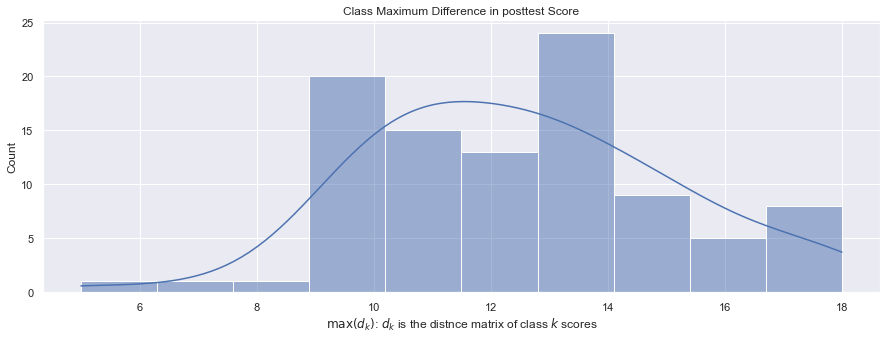

In [19]:
plt.title("Class Maximum Difference in posttest Score")
sns.histplot(x=df.groupby('classroom').apply(lambda _x: _x['posttest'].max() - _x['posttest'].min() ), kde=True, stat='count', ax=plt.gca())
plt.xlabel('$\max{(d_k)}$: $d_k$ is the distnce matrix of class $k$ scores')
plt.show()

The variance of grades within classes is too low, hence, highly biased, and we'd like to get rid of this feaure further ahead.
However, the variance of grades within schools is mostly fine, so we'll keep it.

#### Dimensionality Reduction <a class="anchor" id="pca"></a>


At this part we're gonna use PCA on our data for a few uses:
- Look out for interesting insights on the scattered data in lower dimension
- Understand better the statistical relationship between some of our features

In [21]:
#plt.figure(figsize=(20, 10))
est = plot_decomposition(est=PCA(n_components=3, svd_solver='full'), data=df, color='posttest', marker='school_type',
                         return_estimator=True, title='PCA Transformation on Data', dim=2,
                         drop_columns=['classroom'], drop_color=False, exclude_dtypes=None, method='px')

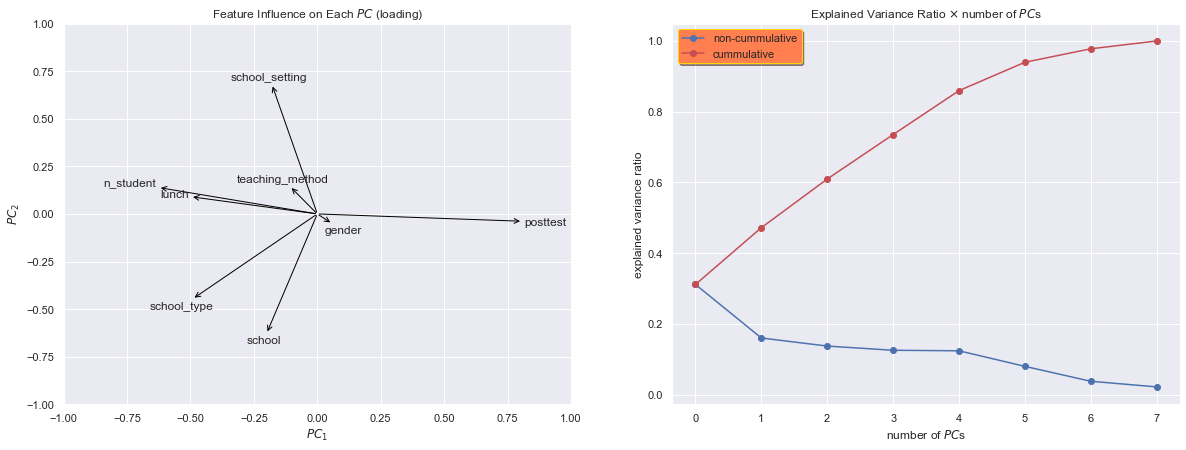

In [22]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
biplot(PCA(n_components=2, svd_solver='full'), df.drop(columns=['classroom']), show=False)
plt.subplot(1, 2, 2)
plot_xVarRatio(df.drop(columns=['classroom']), show=False)

plt.show()

So there are a few interesting things coming up from the plots above:
- As already been seen in one of the figures above, the PCA shows us that the number of students in a class is negativey effecting the posttest scores in the class.
- There are many homogeneous clusters scattered over the plot of the components, and the common attribute is seem to be the school (could be seen clearer if the "marker" parameter is set to 'school'). 
- Some features are oddly seem correlated with each other(number of students in the class & lunch qualification, posttest & gender).
- The explained variance ratio figure suggests that there are 1-2 disposable features (almost no gain in the last two). We won't remove any feature anyway, we have only a few of them already.

## Part 2: Hypothesis Testing <a class="anchor" id="hypt"></a>

### Effect Size <a class="anchor" id="effs"></a>

Next, we'll question whether the differences, of posttest scores, between some groups in the data, are significant. But first, we're going to use the **Cohen’s $d$ effect size** to determine the effect size, ofcourse, of some features in the data.

The **Cohen’s $d$ effect size** is mathematically denoted by:

<center> $d = \frac{\bar{x}_1 - \bar{x}_2}{s} $ : $\bar{x}_1, \bar{x}_2$ are the averages of each group, and </center>

<center> $s = \sqrt{\frac{(n_1-1) s_1^2 + (n_2-1) s_2^2}{n_1 + n_2}} $ : $s_1, s_2$ are the standard deviation of each group </center>

The value of $d$ should be interpreted with the following table:

| d | Effect Size |
| --- | --- |
| **0.01** | **Very Small** |
| **0.2** | **Small** |
| **0.5** | **Medium** |
| **0.8** | **Large** |
| **1.0** | **Very Large** |
| **2.0** | **Huge** |

More info about the method could be found [here](https://en.wikipedia.org/wiki/Effect_size#Difference_family:_Effect_sizes_based_on_differences_between_means).

In [23]:
df['n_students>23'] = df['n_student'] > 23

pd.concat([cohens_d_test(df, 'posttest', 'gender', 'Gender Effect Size on posttest scores'), 
           cohens_d_test(df, 'posttest', 'lunch', 'Lunch Effect Size on posttest scores'), 
           cohens_d_test(df, 'posttest', 'school_type', 'School Type Effect Size on posttest scores'),
           cohens_d_test(df, 'posttest', 'n_students>23', 'n_students>23 in class Effect Size on posttest scores')], axis=1)

Gender Effect Size on posttest scores  \
size( $x_1$ )                                  1056   
size( $x_2$ )                                  1077   
$E[x_1]$                                       67.0   
$E[x_2]$                                       67.2   
$s$                              13.983176734496732   
$d$                            0.013804927372666429   
Effect Size                              Very Small   

              Lunch Effect Size on posttest scores  \
size( $x_1$ )                                 1215   
size( $x_2$ )                                  918   
$E[x_1]$                                     74.38   
$E[x_2]$                                     57.48   
$s$                             11.203856914642408   
$d$                             1.5083443061024564   
Effect Size                                   Huge   

              School Type Effect Size on posttest scores  \
size( $x_1$ )                                        551   
size( $x_2$ )                                       1582   
$E[x_1]$                                           75.96   
$E[x_2]$                                           64.02   
$s$                                   12.969179309770226   
$d$                                   0.9210646486916781   
Effect Size                                   Very Large   

              n_students>23 in class Effect Size on posttest scores  
size( $x_1$ )                                               1271     
size( $x_2$ )                                                862     
$E[x_1]$                                                   72.46     
$E[x_2]$                                                   59.21     
$s$                                           12.380732489821865     
$d$                                           1.0699472037770215     
Effect Size                                           Very Large

The results above pretty much explain themselves, especially with respect to the splitted posttest scores distribution seen above.

### Gender x Grades <a class="anchor" id="ttest"></a>

In the following test we're going to perform a _t-test_ on whether the posttest scores of male and female are significantly different.

We shall formulate the problem:

Let $A = \{ x_1, x_2, \dots, x_n \}$ and $ B = \{ y_1, y_2, \dots, y_m \}$ be two groups of posttest scores, where every $y \in B$ are iid with mean $\mu_1$, variance $\sigma_1^{2}$ and is a posttest score of a female. Also, every $\forall x \in A$ are iid with mean $\mu_2$, variance $\sigma_2^{2}$ and is a posttest score of a male.

**$\mathbb{H}_0: \mu_1 = \mu_2$** , **$\mathbb{H}_1: \mu_1 \ne \mu_2$** for some $\alpha$ (significance level yet to be picked).

Our statistic, in this test, will be a t-statistic, and our test function is defined by:

<center> $\delta = \begin{cases}1, & \text { if } |t| \leq \theta \\  0, & \text { if } |t| > \theta \end{cases} : \theta = \sqrt{2}\cdot erf^{-1}(1 - \alpha)$ is the critical value. </center>

$\mathbb{H}_0$ is obviously rejected $\iff \delta = 0$.

In [24]:
t = stats.ttest_ind(df.query("gender == 'Male'")['posttest'], df.query("gender == 'Female'")['posttest'])
critical_value = lambda alpha: special.erfinv(1 - alpha)*np.sqrt(2)
delta = lambda t, alpha: alpha < t.pvalue

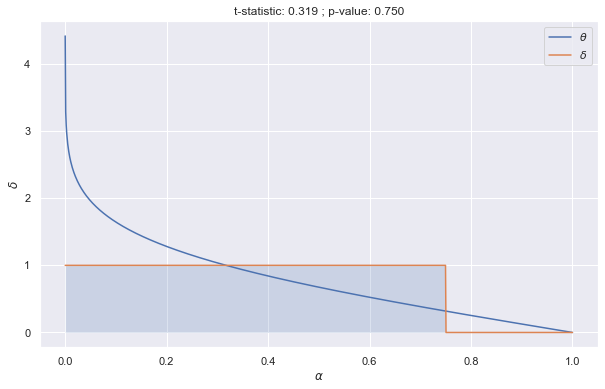

In [25]:
plt.figure(figsize=(10, 6))
alpha = np.linspace(1e-5, 1, 1000)
plt.plot(alpha, critical_value(alpha), label=r'$\theta$')
plt.plot(alpha, delta(t, alpha)*1, label=r'$\delta$')
plt.fill_between(alpha, delta(t, alpha), np.zeros(1000), where=delta(t, alpha)>0, alpha=0.2)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')
plt.title('t-statistic: {:.3f} ; p-value: {:.3f}'.format(t.statistic, t.pvalue))
plt.show()

The figure above shows that for any reasonable $\alpha$ we'd take, $\mathbb{H}_0$ will be accepted. Hence, the difference between male and female posttest scores **is not** significant.

### Number of Students in Class x Grades <a class="anchor" id="ttest2"></a>
The following hypothesis test would show whether the differences, in posttest scores, between students in classes with 24 or more students to others, are significant.

Formally:

Let $A = \{ x_1, x_2, \dots, x_n \}$ and $ B = \{ y_1, y_2, \dots, y_m \}$ be two groups of posttest scores, where every $y \in B$ are iid with mean $\mu_1$, variance $\sigma_1^{2}$ and is a posttest score of a student who has 23 or more classmates. Also, every $\forall x \in A$ are iid with mean $\mu_2$, variance $\sigma_2^{2}$ and is a posttest score of a student who has 22 or less classmates.

**$\mathbb{H}_0: \mu_1 = \mu_2$** , **$\mathbb{H}_1: \mu_1 < \mu_2$** for $\alpha = 0.05$

In [26]:
df = df.drop(columns=['n_students>23'])
t = stats.ttest_ind(df.query("n_student <= 23")['posttest'], df.query("n_student > 23")['posttest'], alternative='greater')
pd.DataFrame(np.array([[t.statistic, t.pvalue]]).T, index=['t-statistic', 'p-value'], columns=['t-test results'])

t-test results
t-statistic    2.423760e+01
p-value       4.007288e-115

The test shows that the difference is highly significant ( $\mathbb{H}_0$ is rejected ), so we could make out of it the conclusion that a large number of students in a class could negatively affect the posttest scores of those students.

## Part 3: Clusterring the Data <a class="anchor" id="clusters"></a>


## Part 4: Regression Modelling <a class="anchor" id="reg"></a>
We're gonna try a few regression models, with optimized hyperparameters (using bayesian optimization).

### Students' Scores ; Gradient Boosting Regressor <a class="anchor" id="gbr"></a>

In [27]:
new_df = df.copy()
y = new_df['posttest'].copy()
new_df = new_df.drop(columns=['posttest', 'classroom'])

In [28]:
cat_transformer = make_column_transformer((OrdinalEncoder(), new_df.select_dtypes(include=['object']).columns.to_list()), remainder='passthrough')

In [51]:
x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size=0.3, shuffle=True, stratify=new_df['school'])

In [52]:
sett = {'learning_rate': {'space': (1e-2, 50), 'f': lambda _x: abs(_x) + 1e-10},
       'loss': {'dtype': str, 'space': ['ls', 'lad', 'quantile', 'huber']},
       'n_estimators': {'dtype': int, 'space': (50, 400)},
       'min_samples_split': {'space': (1e-10, 0.5), 'f': lambda _x: abs(_x)},
       'alpha': {'space': (1e-10, 0.95), 'f': lambda _x: abs(_x)}}

gb = optimize(GradientBoostingRegressor, x_train, y_train, settings=sett, extra_steps=[('transform', cat_transformer), ('sc', StandardScaler())], 
               cv_params={'scoring': 'neg_mean_absolute_error', 'cv': 3}, opt_params={'n_iter': 50}, max_min='min')

|   iter    |  target   |   alpha   | learni... |   loss    | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -1e+06    |  0.3063   |  33.35    |  3.552    |  0.3224   |  367.2    |
|  2        | -1e+06    |  0.6076   |  38.85    |  1.345    |  0.281    |  390.7    |
|  3        | -1e+06    |  0.3699   |  44.11    |  0.3247   |  0.3314   |  180.9    |
|  4        | -1e+06    |  0.02904  |  44.7     |  1.382    |  0.1168   |  232.5    |
|  5        | -1e+06    |  0.1756   |  31.49    |  1.953    |  0.3599   |  100.7    |
|  6        | -5.039    |  0.7962   |  0.1492   |  1.815    |  0.4466   |  50.32    |
|  7        | -1e+06    |  0.95     |  23.15    |  0.0      |  1e-10    |  50.0     |
|  8        | -4.178    |  0.5793   |  0.3455   |  2.791    |  0.1892   |  51.1     |
|  9        | -9.599    |  0.95     |  0.01     |  0.0      |  0.5      |  65.85    |
|  10       | -6.796    |  1e-10    |  0.01     |  0.0

In [53]:
gb = gb.fit(x_train, y_train)
explainer = shap.TreeExplainer(gb.steps[2][1])
shap_values = explainer(gb.steps[1][1].transform(gb.steps[0][1].transform(x_test)))
regression_summary(y_test, gb.predict(x_test), 'Summary for Gradient Boosting Regressor')

Summary for Gradient Boosting Regressor
RMSE                                                  4.056
MAE                                                   3.167
$R^2$                                                 0.917
MedAE                                                 2.574
Explained Variance                                    0.918

The summary table shows that the model is averagely (and medianly) missing the students scores by ~3 points, which is pretty simillar to the usual standard deviation in scores within classes (a feature we tagged as biased). Moreover, the explained variance is high, so we'd take this model as a successful one.

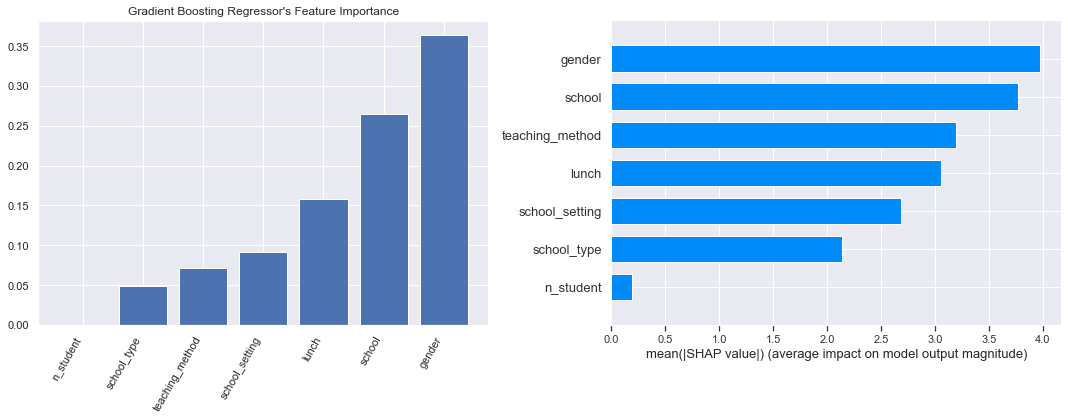

In [54]:
plt.subplot(1, 2, 1)
plt.title("Gradient Boosting Regressor's Feature Importance")
plot_important_features(gb.steps[2][1].feature_importances_, x_train.columns, ax=plt.gca())
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values.values, x_test, plot_type="bar", show=False, plot_size=(15, 6))
plt.tight_layout()
plt.show()

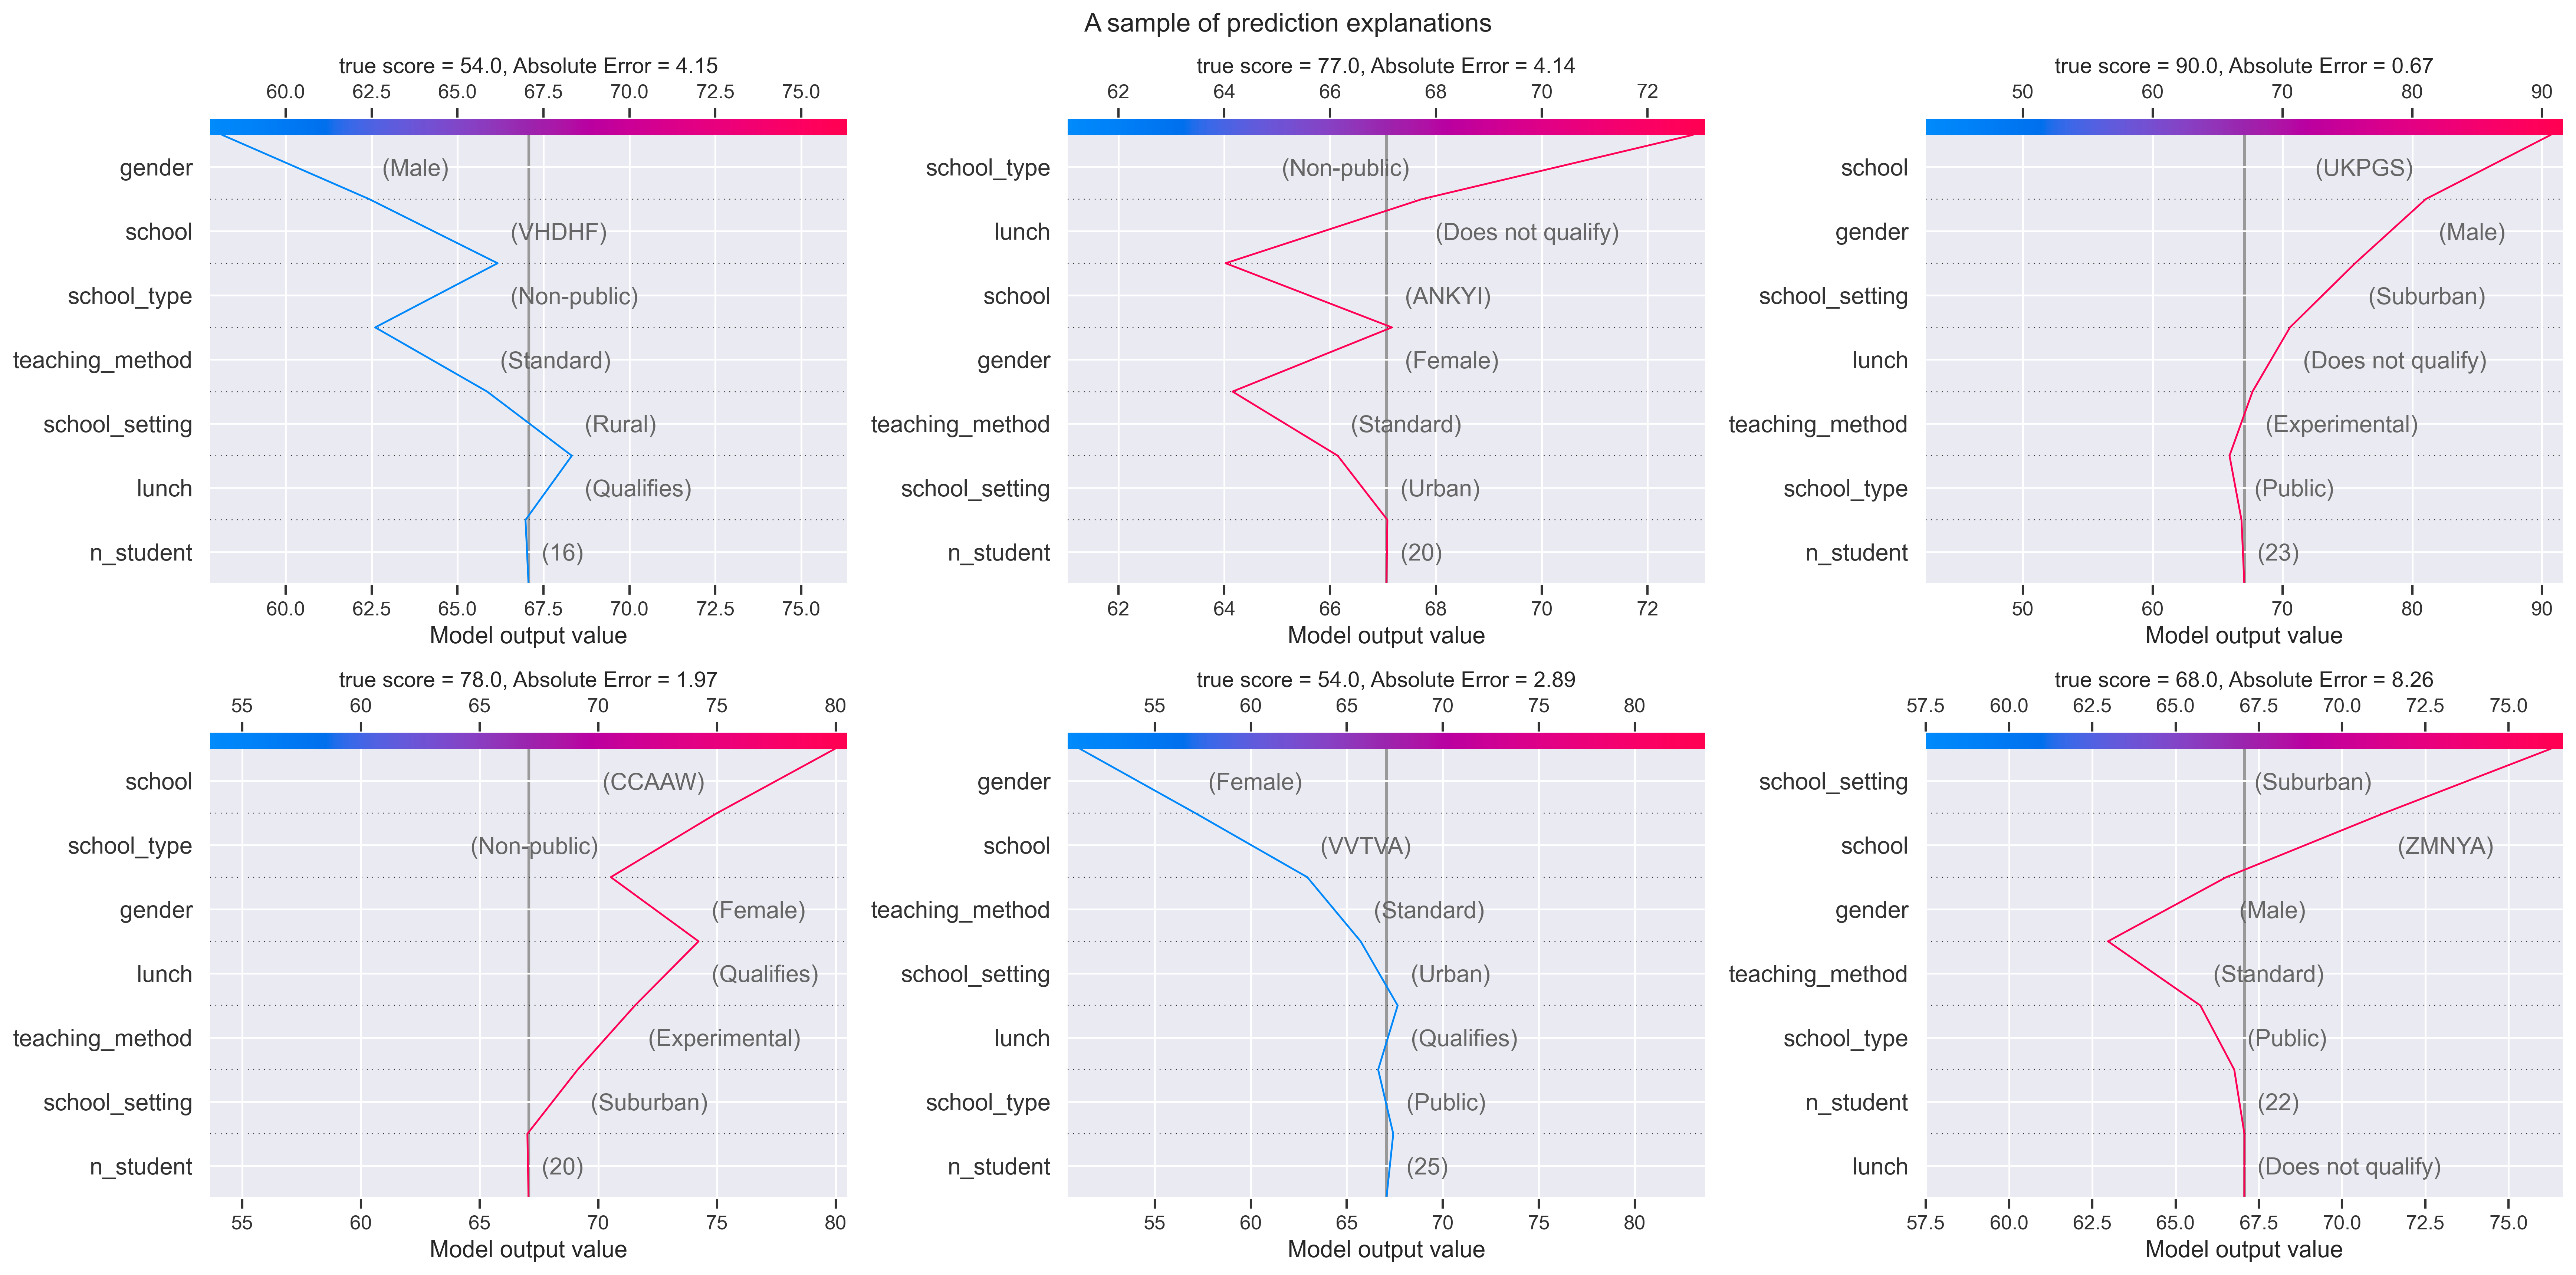

In [55]:
plt.figure(figsize=(20, 10), dpi=350)
plt.suptitle('A sample of prediction explanations')
n_samples = 6
indexes = np.random.randint(0, len(y_test)-1, n_samples)
for i, j in enumerate(indexes):
    plt.subplot(2, 3, i+1)
    title = 'true score = {}, Absolute Error = {:.2f}'.format(y_test.iloc[j], mean_absolute_error(y_test.iloc[j:j+1], gb.predict(x_test.iloc[j:j+1])))
    shap.decision_plot(shap_values.base_values[j], shap_values.values[j], x_test.iloc[j], show=False, title=title, auto_size_plot=False)
plt.tight_layout()
plt.show()

### Class Scores Average ; SVM Regressor <a class="anchor" id="svm"></a>

In [37]:
sett = {'degree': {'dtype': int, 'space': (3, 10)},
        'C': {'space': (1e-2, 50)},
        'gamma': {'space': (1e-3, 0.99), 'f': lambda _x: min(abs(_x), 0.99)},
        'coef0': {'space': (1e-5, 10), 'f': lambda _x: abs(_x)},
        'kernel': {'dtype': str, 'space': ['linear', 'poly', 'rbf']},
       'epsilon': {'space': (0.01, 3.5), 'f': lambda _x: abs(_x)}}

svm = optimize(SVR, x_train, y_train, settings=sett, extra_steps=[('transform', cat_transformer), ('sc', StandardScaler())], 
               cv_params={'scoring': 'neg_mean_absolute_error', 'cv': 3}, opt_params={'n_iter': 50}, max_min='min')

|   iter    |  target   |     C     |   coef0   |  degree   |  epsilon  |   gamma   |  kernel   |
-------------------------------------------------------------------------------------------------
|  1        | -4.639    |  19.54    |  0.06378  |  3.226    |  2.49     |  0.141    |  2.539    |
|  2        | -7.568    |  45.23    |  9.366    |  7.177    |  0.7088   |  0.01265  |  0.07284  |
|  3        | -7.576    |  1.424    |  9.12     |  9.117    |  1.364    |  0.0437   |  0.8102   |
|  4        | -3.848    |  36.33    |  7.34     |  7.971    |  0.472    |  0.6906   |  2.151    |
|  5        | -7.565    |  11.34    |  7.274    |  4.071    |  1.817    |  0.5865   |  0.06055  |
|  6        | -4.556    |  23.42    |  1.422    |  7.109    |  2.301    |  0.3108   |  1.265    |
|  7        | -3.859    |  31.17    |  5.198    |  7.174    |  0.9361   |  0.6638   |  2.515    |
|  8        | -3.808    |  35.14    |  1e-05    |  3.0      |  3.5      |  0.99     |  3.0      |
|  9        | -3.704

|  51       | -3.82     |  33.35    |  5.017    |  3.419    |  3.5      |  0.99     |  3.0      |
|  52       | -3.7      |  35.25    |  8.172    |  3.801    |  0.115    |  0.99     |  3.0      |
|  53       | -3.793    |  37.27    |  10.0     |  5.006    |  3.5      |  0.99     |  3.0      |
|  54       | -4.077    |  28.51    |  1.912    |  9.891    |  0.2821   |  0.3837   |  2.84     |
|  55       | -3.743    |  50.0     |  5.907    |  10.0     |  3.5      |  0.99     |  3.0      |
Final result: {'target': -3.6325686681722185, 'params': {'C': 50.0, 'coef0': 1e-05, 'degree': 3.0, 'epsilon': 0.01, 'gamma': 0.99, 'kernel': 3.0}}


In [74]:
#svm = svm.fit(x_train, y_train)
#explainer_2 = shap.KernelExplainer(svm.steps[2][1].predict, svm.steps[1][1].transform(svm.steps[0][1].transform(x_train)))
shap_values_2 = explainer_2.shap_values(svm.steps[1][1].transform(svm.steps[0][1].transform(x_test.iloc[:20])))
regression_summary(y_test, svm.predict(x_test), 'Summary for SVM Regressor')

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

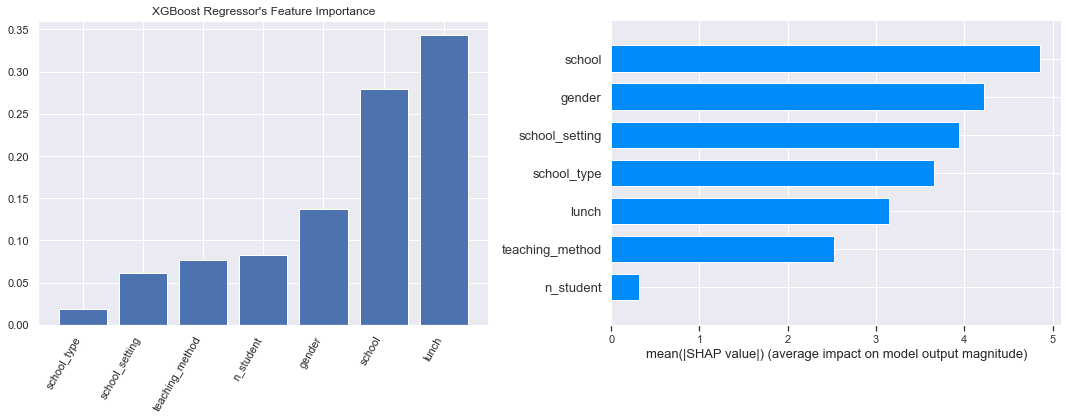

In [37]:
shap.summary_plot(shap_values_2, x_test, plot_type="bar", show=False, plot_size=(15, 6))
plt.tight_layout()
plt.show()